In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from PIL import Image
import warnings
import joblib  # for saving models
warnings.filterwarnings('ignore')

# --- Parameters ---
data_dir = '../data/soil-classification-part-2'
train_image_dir = os.path.join(data_dir, 'train')
test_image_dir = os.path.join(data_dir, 'test')
train_labels_csv = os.path.join(data_dir, 'train_labels.csv')
test_ids_csv = os.path.join(data_dir, 'test_ids.csv')
image_size = (224, 224)
normal_class_label = 1
output_submission_csv = 'submission.csv'
model_save_path = '../data/oneclass_svm_model.joblib'
scaler_save_path = '../data/scaler.joblib'
pca_save_path = '../data/pca.joblib'

# --- Utility function ---
def load_and_preprocess(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(image_size)
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# ===========================
# 1. Preprocessing
# ===========================
print("Starting preprocessing...")
train_labels_df = pd.read_csv(train_labels_csv)
print(f"Loaded train labels: {train_labels_df.shape[0]} samples")

train_one_class_df = train_labels_df[train_labels_df['label'] == normal_class_label]
print(f"Filtered {train_one_class_df.shape[0]} samples for class {normal_class_label}")

train_image_paths = [
    os.path.join(train_image_dir, f"{img_id}")
    for img_id in train_one_class_df['image_id']
]

train_images = np.vstack([load_and_preprocess(p) for p in train_image_paths])
print(f"Loaded and preprocessed {train_images.shape[0]} train images")

base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
train_features = base_model.predict(train_images, verbose=1)
print(f"Extracted train features shape: {train_features.shape}")

test_ids_df = pd.read_csv(test_ids_csv)
test_image_paths = [
    os.path.join(test_image_dir, f"{img_id}")
    for img_id in test_ids_df['image_id']
]

test_images = np.vstack([load_and_preprocess(p) for p in test_image_paths])
print(f"Loaded and preprocessed {test_images.shape[0]} test images")

test_features = base_model.predict(test_images, verbose=1)
print(f"Extracted test features shape: {test_features.shape}")

# ===========================
# 2. Training
# ===========================
print("Starting training...")
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(train_features_scaled)

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
ocsvm.fit(train_features_pca)

# Save models
joblib.dump(ocsvm, model_save_path)
joblib.dump(scaler, scaler_save_path)
joblib.dump(pca, pca_save_path)
print(f"Saved One-Class SVM to '{model_save_path}'")
print(f"Saved scaler to '{scaler_save_path}'")
print(f"Saved PCA to '{pca_save_path}'")

# Optional: evaluate on train data
train_pred = ocsvm.predict(train_features_pca)
n_anomalies_train = (train_pred == -1).sum()
print(f"Training anomalies detected: {n_anomalies_train} out of {len(train_pred)}")

# ===========================
# 3. Inference
# ===========================
print("Starting inference...")
test_features_scaled = scaler.transform(test_features)
test_features_pca = pca.transform(test_features_scaled)
test_pred = ocsvm.predict(test_features_pca)

# ===========================
# 4. Postprocessing
# ===========================
print("Starting postprocessing...")
test_ids_df['label'] = test_pred
test_ids_df['label'] = test_ids_df['label'].replace(-1, 0)
test_ids_df.to_csv(output_submission_csv, index=False)
print(f"Saved submission to '{output_submission_csv}'")


Starting preprocessing...
Loaded train labels: 1222 samples
Filtered 1222 samples for class 1
Loaded and preprocessed 1222 train images
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step
Extracted train features shape: (1222, 2048)
Loaded and preprocessed 967 test images
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step
Extracted test features shape: (967, 2048)
Starting training...
Saved One-Class SVM to 'oneclass_svm_model.joblib'
Saved scaler to 'scaler.joblib'
Saved PCA to 'pca.joblib'
Training anomalies detected: 108 out of 1222
Starting inference...
Starting postprocessing...
Saved submission to 'submission.csv'


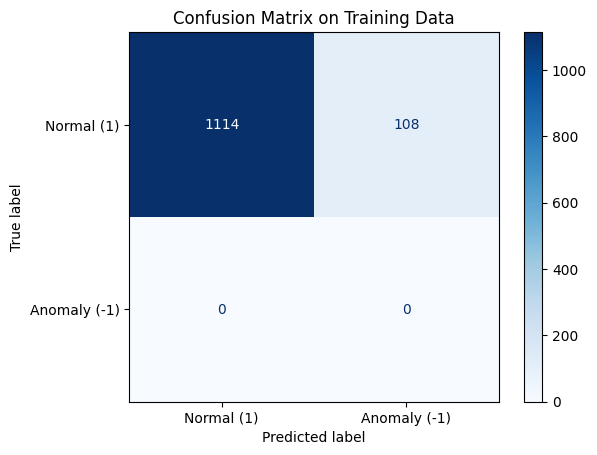

Confusion matrix:
 [[1114  108]
 [   0    0]]


In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# True labels (all normal in training data)
true_train_labels = np.ones_like(train_pred)

# Compute confusion matrix
cm = confusion_matrix(true_train_labels, train_pred, labels=[1, -1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (1)', 'Anomaly (-1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Training Data')
plt.show()

# Print confusion matrix values
print("Confusion matrix:\n", cm)


Classification report on training data:
              precision    recall  f1-score   support

     Anomaly       0.00      0.00      0.00         0
      Normal       1.00      0.91      0.95      1222

    accuracy                           0.91      1222
   macro avg       0.50      0.46      0.48      1222
weighted avg       1.00      0.91      0.95      1222



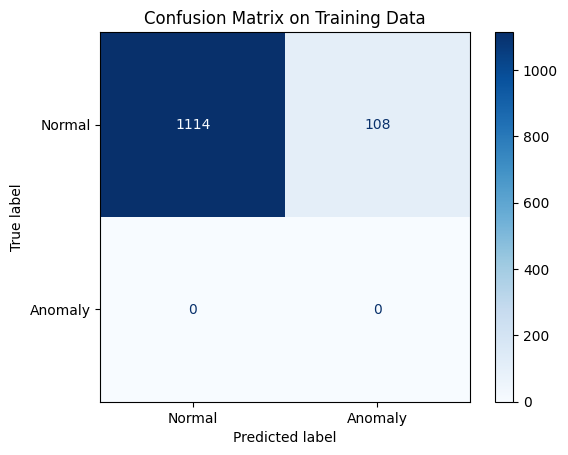

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# True labels (all normal in training)
true_train_labels = np.ones_like(train_pred)

# Convert -1 to 0 for anomaly (for sklearn metrics)
predicted_train_labels = np.where(train_pred == 1, 1, 0)
true_train_labels_binary = np.ones_like(predicted_train_labels)  # all normal (1)

# Classification report
print("Classification report on training data:")
print(classification_report(true_train_labels_binary, predicted_train_labels, target_names=['Anomaly', 'Normal']))

# Confusion matrix
cm = confusion_matrix(true_train_labels_binary, predicted_train_labels, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Training Data')
plt.show()
